# CuPy - Cuda Python
## _GPU acceleration of embarrassingly parallel tasks_

[![N|Solid](https://developer.nvidia.com/sites/default/files/akamai/cupy.png)](https://nvidia.github.io/cuda-python/overview.html)

GPU-accelerated computing with Python

- Simple integration with SciPy, Xarray and Dask
- ✨Magic ✨


[Users Guide](https://readthedocs.org/projects/cupy/downloads/pdf/stable/)

[cupy-xarray](https://github.com/xarray-contrib/cupy-xarray)


In [1]:
import cupy as cp
import dask.array as da

### Generate some synthetic data for testing

This will be fast as we are doing three things that aid in the speed of this cell
- Not using disk I/O
- Not moving data from RAM to graphics memory
- Using GPU to generate data in a parellel manner

In [2]:
# Define synthetic data dimensions
lat = cp.linspace(0, 10, 501)  # Replace with your desired latitude values
lon = cp.linspace(0, 10, 502)  # Replace with your desired longitude values
time = cp.arange(0, 1234)      # Replace with your desired time values

# Generate synthetic data using meshgrid
lon_mesh, lat_mesh, time_mesh = cp.meshgrid(lon, lat, time, indexing='ij')

# Create a synthetic data array with random values
synthetic_data = cp.random.rand(lat.shape[0], lon.shape[0], time.shape[0])

# Convert synthetic data to a Dask array
data_dask = da.from_array(synthetic_data, chunks=(501, 502, -1))  # Chunking along the 'time' axis


### Calculate percentiles for the grid

Data have been loaded (created) into GPU memory, we now leverage the GPU and pull the data we need. 

Saving out intermediate results can REALLY be a bottleneck here, as passing data between the GPU and CPU is slow by comparison.



In [3]:
# Define the desired percentile(s)
percentiles = [50, 80, 90, 95, 99, 99.5, 99.9]

# Define the axis along which to calculate percentiles (default 'time')
axis = 2  # Calculate percentiles along the 'time' axis (axis 2)

# Function to calculate percentiles using cuPy
def calculate_percentiles(chunk):
    # Perform GPU-accelerated percentile calculation
    return cp.percentile(chunk, q=percentiles, axis=axis)  # GPU computation

# Use Dask's map_blocks to apply the percentile calculation to each chunk 
# We use map_blocks over @dask.delayed in this case, that implementation has been more error prone in initial testing
percentile_results = data_dask.map_blocks(calculate_percentiles, dtype='float64')

# Compute the results (this triggers the computation)
percentile_results = percentile_results.compute()


In [4]:
# we are expecting an array of shape len(percentiles), lat, lon
cp.shape(percentile_results)

(7, 501, 502)

In [5]:
#we need to call .get() to pull these values from the GPU for CPU plotting. 
percentile_results[0, :, :].get()

array([[0.48186389, 0.49874707, 0.48450259, ..., 0.51057695, 0.49712548,
        0.52936266],
       [0.52146538, 0.48361402, 0.52115282, ..., 0.48708531, 0.5066307 ,
        0.48362736],
       [0.48337671, 0.49581745, 0.49423402, ..., 0.5026587 , 0.49838713,
        0.48982289],
       ...,
       [0.51837521, 0.49843311, 0.49729583, ..., 0.49994338, 0.53833437,
        0.50474303],
       [0.48713013, 0.48705814, 0.49711232, ..., 0.50990906, 0.52444859,
        0.52435812],
       [0.52639704, 0.51229311, 0.50179743, ..., 0.48441628, 0.51427066,
        0.49180705]])

### Finally plot the results

As data are from a uniform distribution [0,1] a 99.9th percentile should yeild the associated range (dependent on the number of samples for convergence) on the cbar


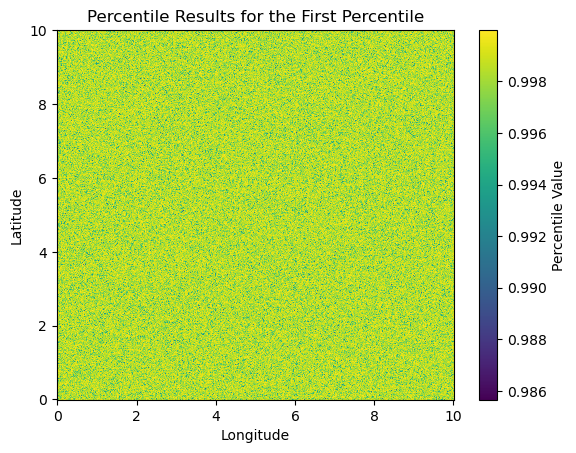

In [6]:
import matplotlib.pyplot as plt

# as defined above: percentiles = [50, 80, 90, 95, 99, 99.5, 99.9]
data_to_plot = percentile_results[6, :, :].get()  #.get() is necessary to move data from the GPU memory to the CPU side

# Create a pcolormesh plot
plt.pcolormesh(lon.get(), lat.get(), data_to_plot, cmap='viridis')
plt.colorbar(label='Percentile Value')
plt.title('Percentile Results for the First Percentile')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
